In [56]:
import torch
from torch_geometric.data import Data
import pandas as pd

def load_custom_data(nodes_path: str, edges_path: str) -> Data:
    """
    加载自定义的图数据集。
    
    参数:
        nodes_path (str): 节点数据的CSV文件路径。
        edges_path (str): 边数据的CSV文件路径。
    
    返回:
        Data: PyTorch Geometric 的数据对象。
        dict: 节点名称到ID的映射。
        dict: ID到节点名称的映射。
    """
    # 读取节点数据
    nodes_df = pd.read_csv(nodes_path)
    num_nodes = nodes_df.shape[0]
    
    # 创建节点名称到ID的映射
    node_names = nodes_df['filename'].tolist()
    name_to_id = {name: idx for idx, name in enumerate(node_names)}
    id_to_name = {idx: name for name, idx in name_to_id.items()}
    
    # 节点特征
    feature_cols = [col for col in nodes_df.columns if col.startswith('feature_')]
    x = torch.tensor(nodes_df[feature_cols].values, dtype=torch.float)
    
    # 读取边数据
    edges_df = pd.read_csv(edges_path)
    
    # 将边的节点名称转换为ID
    edge_index = edges_df[['node1', 'node2']].applymap(lambda name: name_to_id.get(name, -1))
    
    # 检查是否有未映射的节点
    if (edge_index == -1).any().any():
        raise ValueError("存在未在nodes.csv中定义的节点名称。请检查edges.csv中的节点名称是否与nodes.csv一致。")
    
    edge_index = torch.tensor(edge_index.values, dtype=torch.long).t().contiguous()
    
    # 边属性（权重）
    edge_attr = torch.tensor(edges_df['combined_score'].values, dtype=torch.float).unsqueeze(1)
    
    # 创建Data对象
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data, name_to_id, id_to_name

# 示例用法
# data, name_to_id, id_to_name = load_custom_data('nodes.csv', 'edges.csv')
# print(data)


In [57]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from typing import Optional
from torch_geometric.typing import OptTensor
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.utils import get_laplacian
from torch_geometric.nn.inits import glorot, zeros


def get_filter(edge_index, edge_weight, k_taylor, k_filter):
    edge_weight = edge_weight
    num_nodes = maybe_num_nodes(edge_index)
    cos_list = list()
    sin_list = list()
    cos = get_cos(edge_index, edge_weight, k_taylor=k_taylor)
    sin = get_sin(edge_index, edge_weight, k_taylor=k_taylor)

    cos_list.append(torch.eye(n=num_nodes))
    sin_list.append(torch.zeros(size=(num_nodes, num_nodes)))

    for i in range(1, k_filter):
        if i == 1:
            cos_list.append(cos)
            sin_list.append(sin)
        else:
            cos_list.append(cos_list[-1] @ cos - sin_list[-1] @ sin)
            sin_list.append(cos_list[-1] @ sin + sin_list[-1] @ cos)

    return cos_list, sin_list
class CEConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K, normalization='sym', bias=True,
                 cos_list=None, sin_list=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(CEConv, self).__init__(**kwargs)

        assert K > 0
        assert normalization in [None, 'sym', 'rw'], 'Invalid normalization'

        self.k_filter = K
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        self.cos_list = cos_list
        self.sin_list = sin_list

        self.weight = Parameter(torch.Tensor(K, in_channels, out_channels))
        self.a = Parameter(torch.Tensor(K))
        self.b = Parameter(torch.Tensor(K))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.nn.init.uniform_(self.a, a=0.5, b=0.51)
        torch.nn.init.uniform_(self.b, a=0.5, b=0.51)
        glorot(self.weight)
        zeros(self.bias)



    # CEGCN without high-pass filter
    def forward(self, edge_index, edge_weight, x, batch: OptTensor = None):

        Filter = (self.a[0] * self.cos_list[0].to(edge_index.device))  # aI-0b = I
        Tx_0 = x
        out = torch.matmul(torch.matmul(Filter, Tx_0), self.weight[0])
        # out = torch.matmul(x, self.weight[0])

        for k in range(1, self.weight.size(0)):
            Tx_1 = self.propagate(edge_index, edge_weight=edge_weight, x=Tx_0, size=None)
            Tx_0 = Tx_1
            out = out + torch.matmul(Tx_1, self.weight[k])

        if self.bias is not None:
            out += self.bias

        return out


    '''
    def forward(self, edge_index, edge_weight, x, batch: OptTensor = None):

        Filter = (self.a[0] * self.cos_list[0].to(edge_index.device))  # aI-0b = I
        Tx_0 = x
        out = torch.matmul(torch.matmul(Filter, Tx_0), self.weight[0])
        # out = torch.matmul(x, self.weight[0])

        # FL^kX
        for k in range(1, self.weight.size(0)):
            Filter = (self.a[k] * self.cos_list[k].to(edge_index.device) -
                      self.b[k] * self.sin_list[k].to(edge_index.device))
            Tx_1 = self.propagate(edge_index, edge_weight=edge_weight, x=Tx_0, size=None)
            Tx_0 = Tx_1
            Tx_2 = torch.matmul(Filter, Tx_1)
            out = out + torch.matmul(Tx_2, self.weight[k])

        if self.bias is not None:
            out += self.bias

        return out
    '''

    def message(self, x_j, edge_weight):
        # x_j has shape [E, out_channels], edge_weight has shape [1, E]
        return edge_weight.view(-1, 1) * x_j

    def __repr__(self):
        return '{}({}, {}, K={}, normalization={})'.format(
            self.__class__.__name__, self.in_channels, self.out_channels,
            self.weight.size(0), self.normalization)

class CEGCN(nn.Module):
    def __init__(self, num_features: int, hidden_channels: int, embedding_dim: int, K: int, cos_list, sin_list):
        super(CEGCN, self).__init__()
        self.conv1 = CEConv(
            in_channels=num_features, 
            out_channels=hidden_channels, 
            K=K, 
            normalization='sym',
            cos_list=cos_list,
            sin_list=sin_list
        )
        self.conv2 = CEConv(
            in_channels=hidden_channels, 
            out_channels=embedding_dim,  # 输出嵌入维度
            K=K, 
            normalization='sym',
            cos_list=cos_list,
            sin_list=sin_list
        )

    def forward(self, edge_index, edge_weight, x):
        x = self.conv1(edge_index, edge_weight, x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(edge_index, edge_weight, x)
        return x  # 返回节点嵌入
def compute_filter_lists(data: Data, K: int, k_taylor: int):
    """
    计算余弦和正弦滤波器列表。
    """
    edge_index, edge_weight = get_laplacian(data.edge_index, edge_weight=data.edge_attr, normalization='sym')
    cos_list, sin_list = get_filter(edge_index, edge_weight, k_taylor=k_taylor, k_filter=K)
    return cos_list, sin_list


In [58]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, z):
        # 使用点积作为解码器，重构邻接矩阵
        adj_reconstructed = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_reconstructed


In [59]:
class Autoencoder(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, edge_index, edge_weight, x):
        z = self.encoder(edge_index, edge_weight, x)
        adj_reconstructed = self.decoder(z)
        return adj_reconstructed, z


In [60]:
from torch_geometric.utils import to_dense_adj

def train(model: nn.Module, data: Data, optimizer: torch.optim.Optimizer, criterion) -> float:
    model.train()
    optimizer.zero_grad()
    adj_reconstructed, embeddings = model(data.edge_index, data.edge_attr, data.x)
    
    # 将 adj_true 的形状从 [166, 166, 1] 转换为 [166, 166]
    adj_true = to_dense_adj(data.edge_index, edge_attr=data.edge_attr)[0].squeeze(-1)
    
    loss = criterion(adj_reconstructed, adj_true)
    loss.backward()
    optimizer.step()
    return loss.item()


In [61]:
from sklearn.cluster import KMeans
from networkx.algorithms.community import modularity
import networkx as nx

def evaluate(model: nn.Module, data: Data, embeddings: torch.Tensor, num_communities: int = 2) -> list:
    """
    使用K-Means对节点嵌入进行聚类，并计算模块度。
    
    参数:
        model (nn.Module): 训练好的自编码器模型。
        data (Data): 图数据对象。
        embeddings (torch.Tensor): 节点嵌入。
        num_communities (int): 期望的社区数量。
    
    返回:
        list: [模块度值, 预测的社区划分]
    """
    embeddings = embeddings.detach().cpu().numpy()

    # 使用 K-Means 聚类
    kmeans = KMeans(n_clusters=num_communities, random_state=42)
    predicted_communities = kmeans.fit_predict(embeddings)

    # 创建 NetworkX 图
    G = nx.Graph()
    edge_index_np = data.edge_index.cpu().numpy()
    G.add_weighted_edges_from([(src, tgt, weight) for src, tgt, weight in zip(edge_index_np[0], edge_index_np[1], data.edge_attr.cpu().numpy().flatten())])

    # 创建社区列表
    communities = []
    for i in range(num_communities):
        communities.append([node for node, comm in enumerate(predicted_communities) if comm == i])

    # 计算模块度
    mod = modularity(G, communities)

    print(f'Modularity: {mod:.4f}')

    return [mod, predicted_communities]


In [62]:
def visualize_embeddings(embeddings, predicted_communities):
    """
    使用 t-SNE 对节点嵌入进行降维，并绘制散点图。
    """
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 6))

    # 绘制预测社区
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=predicted_communities, cmap='viridis', s=50)
    plt.title('Node Embeddings with Predicted Communities')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.colorbar(scatter)
    plt.show()


def visualize_graph(data: Data, predicted_communities):
    """
    使用 NetworkX 可视化图结构，并根据预测社区对节点着色。
    """
    # 创建 NetworkX 图
    G = nx.Graph()
    edge_index_np = data.edge_index.cpu().numpy()
    G.add_weighted_edges_from([(src, tgt, weight) for src, tgt, weight in zip(edge_index_np[0], edge_index_np[1], data.edge_attr.cpu().numpy().flatten())])

    # 获取节点颜色
    colors = predicted_communities

    # 使用spring_layout布局
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap='viridis', node_size=300)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title('Graph with Predicted Community Detection Results')
    plt.axis('off')
    plt.show()

In [63]:
def get_cos(edge_index, edge_weight, k_taylor):
    L = to_dense_adj(edge_index, edge_attr=edge_weight)[0]
    print(f'[get_cos] L shape before squeeze: {L.shape}')
    
    # 检查并去除最后一个维度
    if L.dim() == 4 and L.size(0) == 1 and L.size(-1) == 1:
        L = L.squeeze(0).squeeze(-1)
        print(f'[get_cos] L shape after squeeze: {L.shape}')
    elif L.dim() == 3 and L.size(-1) == 1:
        L = L.squeeze(-1)
        print(f'[get_cos] L shape after squeeze: {L.shape}')
    elif L.dim() == 2:
        print(f'[get_cos] L shape is already 2D: {L.shape}')
    else:
        raise ValueError(f'[get_cos] Unexpected L shape: {L.shape}')
    
    L2 = torch.matmul(L, L)
    print(f'[get_cos] L2 shape: {L2.shape}')
    
    # 实现余弦滤波器的具体逻辑
    cos = torch.eye(L2.shape[0], device=L2.device)  # 示例：使用单位矩阵
    return cos

def get_sin(edge_index, edge_weight, k_taylor):
    L = to_dense_adj(edge_index, edge_attr=edge_weight)[0]
    print(f'[get_sin] L shape before squeeze: {L.shape}')
    
    # 检查并去除最后一个维度
    if L.dim() == 4 and L.size(0) == 1 and L.size(-1) == 1:
        L = L.squeeze(0).squeeze(-1)
        print(f'[get_sin] L shape after squeeze: {L.shape}')
    elif L.dim() == 3 and L.size(-1) == 1:
        L = L.squeeze(-1)
        print(f'[get_sin] L shape after squeeze: {L.shape}')
    elif L.dim() == 2:
        print(f'[get_sin] L shape is already 2D: {L.shape}')
    else:
        raise ValueError(f'[get_sin] Unexpected L shape: {L.shape}')
    
    L2 = torch.matmul(L, L)
    print(f'[get_sin] L2 shape: {L2.shape}')
    
    # 实现正弦滤波器的具体逻辑
    sin = torch.zeros_like(L2)  # 示例：初始化为零
    return sin

def get_filter(edge_index, edge_weight, k_taylor, k_filter):
    """
    根据拉普拉斯矩阵计算余弦和正弦滤波器列表。
    """
    cos_list = []
    sin_list = []
    cos = get_cos(edge_index, edge_weight, k_taylor=k_taylor)
    sin = get_sin(edge_index, edge_weight, k_taylor=k_taylor)
    
    # 示例：添加单位矩阵作为 cos(0) = I
    cos_list.append(torch.eye(cos.shape[0], device=cos.device))
    sin_list.append(torch.zeros_like(sin))
    
    for k in range(1, k_filter + 1):
        # 示例：按比例缩放 cos 和 sin
        cos_scaled = cos * k
        sin_scaled = sin * k
        cos_list.append(cos_scaled)
        sin_list.append(sin_scaled)
    
    print(f'[get_filter] cos_list length: {len(cos_list)}, sin_list length: {len(sin_list)}')
    return cos_list, sin_list
def compute_filter_lists(data: Data, K: int, k_taylor: int):
    """
    计算余弦和正弦滤波器列表。
    """
    edge_index, edge_weight = get_laplacian(data.edge_index, edge_weight=data.edge_attr, normalization='sym')
    # 如果 edge_weight 维度过高，进行适当的调整
    if edge_weight.dim() > 1 and edge_weight.size(-1) == 1:
        edge_weight = edge_weight.squeeze(-1)
    cos_list, sin_list = get_filter(edge_index, edge_weight, k_taylor=k_taylor, k_filter=K)
    print(f'[compute_filter_lists] cos_list size: {[c.shape for c in cos_list]}, sin_list size: {[s.shape for s in sin_list]}')
    return cos_list, sin_list


In [64]:
def apply_complex_filter(data: Data) -> Data:
    """
    对图数据应用复杂过滤操作，例如移除自环并重新添加。
    """
    edge_index, edge_attr = data.edge_index, data.edge_attr

    # 1. 移除自环
    edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)

    # 2. 添加自环，填充值为1
    edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=1.0)

    # 更新数据对象
    data.edge_index = edge_index.to(device)
    data.edge_attr = edge_attr.to(device)

    return data

In [65]:
#损失函数定义
def reconstruction_loss(edge_index, edge_attr, embeddings):
    # 取出边的两端
    src, dst = edge_index
    # 计算嵌入的相似性（内积）
    similarity = (embeddings[src] * embeddings[dst]).sum(dim=1)
    # 将内积通过 Sigmoid 转换为概率
    similarity = torch.sigmoid(similarity)
    # 计算实际边与预测边的重构误差
    loss = torch.mean((edge_attr.squeeze() - similarity) ** 2)
    return loss

def clustering_loss(embeddings, centroids, Q):
    # Q 是嵌入到社区的软分配概率
    P = Q ** 2 / Q.sum(dim=0)  # 目标分布
    P = P / P.sum(dim=1, keepdim=True)
    loss = torch.sum(P * torch.log(P / Q))
    return loss
def total_loss(edge_index, edge_attr, embeddings, centroids, Q, alpha=0.1):
    recon_loss = reconstruction_loss(edge_index, edge_attr, embeddings)
    Q = calculate_Q(embeddings, centroids)
    cluster_loss = clustering_loss(embeddings, centroids, Q)
    return recon_loss + alpha * cluster_loss
def calculate_Q(embeddings, centroids):
    distances = torch.cdist(embeddings, centroids, p=2)  # 计算欧氏距离
    Q = torch.softmax(-distances, dim=1)  # 转换为分布
    return Q

def train(autoencoder, data, optimizer, centroids, alpha=0.1):
    autoencoder.train()
    optimizer.zero_grad()
    
    # 前向传播
    adj_reconstructed, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)
    
    # 计算总损失
    loss = total_loss(data.edge_index, data.edge_attr, embeddings, centroids,alpha)
    loss.backward()
    
    # 更新模型参数
    optimizer.step()
    
    # 更新社区中心
    with torch.no_grad():
        centroids -= 0.01 * centroids.grad  # 手动更新社区中心
        centroids.grad.zero_()
    
    return loss.item()


In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
nodes_path = "/users/lfluo/downloads/nodes3.csv"  # 替换为您的nodes.csv路径
edges_path = "/users/lfluo/downloads/edges2.csv"  # 替换为您的edges.csv路径
data, name_to_id, id_to_name = load_custom_data(nodes_path, edges_path)
data = apply_complex_filter(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/var/folders/mf/j8hsww414zqdvq9b2tzt2b2h0000gn/T/ipykernel_5731/4179737846.py:35: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [68]:
print(data)

Data(x=[776, 128], edge_index=[2, 6073], edge_attr=[6073, 1])


In [ ]:
    L = to_dense_adj(edge_index, edge_attr=edge_weight)[0]
    print(f'L shape: {L.shape}')  # 添加调试语句
    L2 = torch.matmul(L, L)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 计算滤波器列表
K = 2          # 设置滤波器阶数为 2
k_taylor = 10  # 设置泰勒级数展开的阶数
cos_list, sin_list = compute_filter_lists(data, K=K, k_taylor=k_taylor)

[get_cos] L shape before squeeze: torch.Size([776, 776])
[get_cos] L shape is already 2D: torch.Size([776, 776])
[get_cos] L2 shape: torch.Size([776, 776])
[get_sin] L shape before squeeze: torch.Size([776, 776])
[get_sin] L shape is already 2D: torch.Size([776, 776])
[get_sin] L2 shape: torch.Size([776, 776])
[get_filter] cos_list length: 3, sin_list length: 3
[compute_filter_lists] cos_list size: [torch.Size([776, 776]), torch.Size([776, 776]), torch.Size([776, 776])], sin_list size: [torch.Size([776, 776]), torch.Size([776, 776]), torch.Size([776, 776])]


In [119]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# 定义编码器
embedding_dim = 16  # 嵌入维度
K = 3  # 示例的图卷积层数


encoder = CEGCN(
    num_features=data.num_node_features, 
    hidden_channels=16, 
    embedding_dim=embedding_dim,
    K=K,
    cos_list=cos_list,
    sin_list=sin_list
).to(device)

# 定义解码器
decoder = Decoder(embedding_dim=embedding_dim).to(device)

# 定义自编码器模型
autoencoder = Autoencoder(encoder, decoder).to(device)

# 定义优化器
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=5e-4)

# 初始化社区中心
num_clusters = 3  # 假设有 3 个社区
centroids = torch.rand(num_clusters, embedding_dim, requires_grad=True, device=device)

# 训练模型
num_epochs = 2000
print_every = 10

#总损失为 重构损失 + 聚类损失，通过 alpha 参数平衡两者的重要性。默认值为 0.1。如果重构邻接矩阵更重要，可以减小；如果社区聚类更重要，可以增大。
for epoch in range(1, num_epochs + 1):
    loss = train(autoencoder, data, optimizer, centroids, alpha=0.1)
    
    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        
        # 打印梯度信息（可选）
        for name, param in autoencoder.named_parameters():
            if param.grad is not None:
                grad_mean = param.grad.abs().mean().item()
                grad_min = param.grad.min().item()
                grad_max = param.grad.max().item()
                print(f"Layer: {name}, Grad Mean: {grad_mean:.6f}, Grad Min: {grad_min:.6f}, Grad Max: {grad_max:.6f}")

# 获取最终节点嵌入
autoencoder.eval()
with torch.no_grad():
    adj_reconstructed, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

Epoch: 010, Loss: 0.4388
Layer: encoder.conv1.weight, Grad Mean: 0.007738, Grad Min: -0.256101, Grad Max: 0.321307
Layer: encoder.conv1.a, Grad Mean: 0.000472, Grad Min: -0.001416, Grad Max: 0.000000
Layer: encoder.conv1.bias, Grad Mean: 0.164246, Grad Min: -0.448222, Grad Max: 0.569783
Layer: encoder.conv2.weight, Grad Mean: 0.013843, Grad Min: -0.398913, Grad Max: 0.395302
Layer: encoder.conv2.a, Grad Mean: 0.003274, Grad Min: 0.000000, Grad Max: 0.009821
Layer: encoder.conv2.bias, Grad Mean: 0.130194, Grad Min: -0.275807, Grad Max: 0.305280
Epoch: 020, Loss: 0.2509
Layer: encoder.conv1.weight, Grad Mean: 0.003228, Grad Min: -0.093502, Grad Max: 0.173530
Layer: encoder.conv1.a, Grad Mean: 0.000053, Grad Min: 0.000000, Grad Max: 0.000158
Layer: encoder.conv1.bias, Grad Mean: 0.040609, Grad Min: -0.097468, Grad Max: 0.191482
Layer: encoder.conv2.weight, Grad Mean: 0.005896, Grad Min: -0.157813, Grad Max: 0.155209
Layer: encoder.conv2.a, Grad Mean: 0.001535, Grad Min: 0.000000, Grad Max

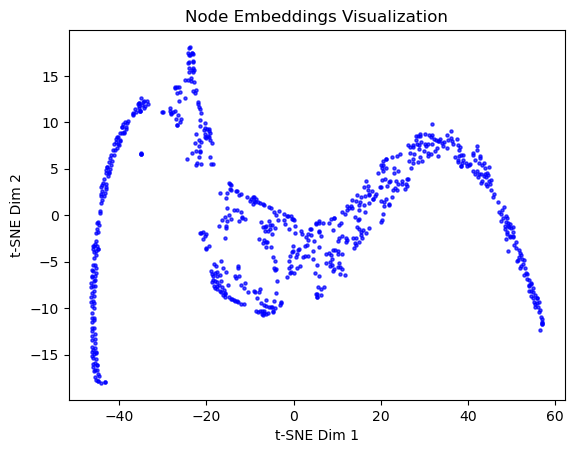

In [120]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 embeddings 是训练后的节点嵌入
embeddings = embeddings.cpu().numpy()

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 可视化
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, c='blue', alpha=0.7)
plt.title("Node Embeddings Visualization")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(embeddings)


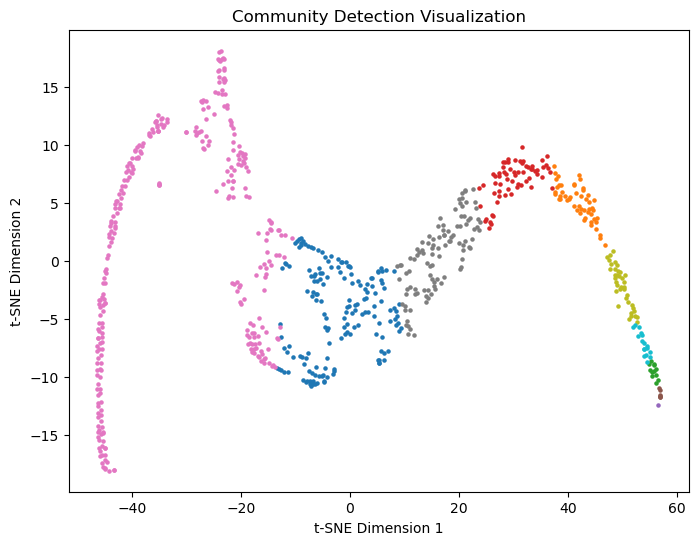

Community detection results saved to community_detection_results_a1.csv


In [122]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# 假设数据和模型已经训练完成，以下是提取社区划分的完整流程

# 1. 获取节点嵌入
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

# 2. 使用 K-Means 进行社区划分
num_clusters = 10  # 社区数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(embeddings.cpu().numpy())

# 3. 降维可视化（可选，便于验证社区分布）
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

# 可视化社区划分结果（根据降维后的坐标）
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = embeddings_2d[predicted_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Community {cluster_id}", s=5)

plt.title("Community Detection Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# 4. 将社区划分结果保存为 CSV
# 创建 DataFrame 包含节点 ID 和社区编号
node_ids = torch.arange(data.num_nodes).cpu().numpy()
df = pd.DataFrame({
    'node_id': node_ids,
    'community': predicted_labels
})
df['node_feature'] = data.x.cpu().numpy()[:, 0]  # 取第一个特征

# 保存为 CSV 文件
output_file = "community_detection_results_a1.csv"
df.to_csv(output_file, index=False)
print(f"Community detection results saved to {output_file}")


/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



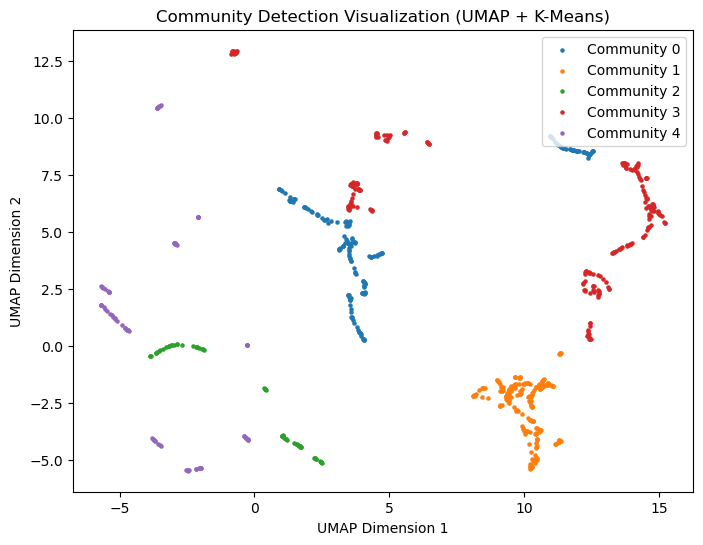

Community detection results saved to community_detection_results.csv


In [126]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

# 假设数据和模型已经训练完成，以下是提取社区划分的完整流程
# 1. 获取节点嵌入
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

# 2. 使用 UMAP 进行降维
umap_model = umap.UMAP(n_components=3, random_state=42,n_neighbors=4)
embeddings_2d = umap_model.fit_transform(embeddings.cpu().numpy())


# 3. 使用 K-Means 进行社区划分（在降维后的数据上进行聚类）
num_clusters = 5  # 假设有 3 个社区
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(embeddings_2d)

# 4. 可视化社区划分结果（基于降维后的坐标）
plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = embeddings_2d[predicted_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Community {cluster_id}", s=5)
plt.legend()
plt.title("Community Detection Visualization (UMAP + K-Means)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# 5. 将社区划分结果保存为 CSV
# 创建 DataFrame 包含节点 ID 和社区编号
node_ids = torch.arange(data.num_nodes).cpu().numpy()
df = pd.DataFrame({
    'node_id': node_ids,
    'community': predicted_labels
})
df['node_feature'] = data.x.cpu().numpy()[:, 0]  # 假设取第一个特征

# 保存为 CSV 文件
output_file = "community_detection_results.csv"
df.to_csv(output_file, index=False)
print(f"Community detection results saved to {output_file}")

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 21010 (\N{CJK UNIFIED IDEOGRAPH-5212}) missing from font(s) DejaVu Sans.

/opt/anaconda3/envs/mod_det/lib/python3.11/site-packages/IPython/core/pylabtools.py:1

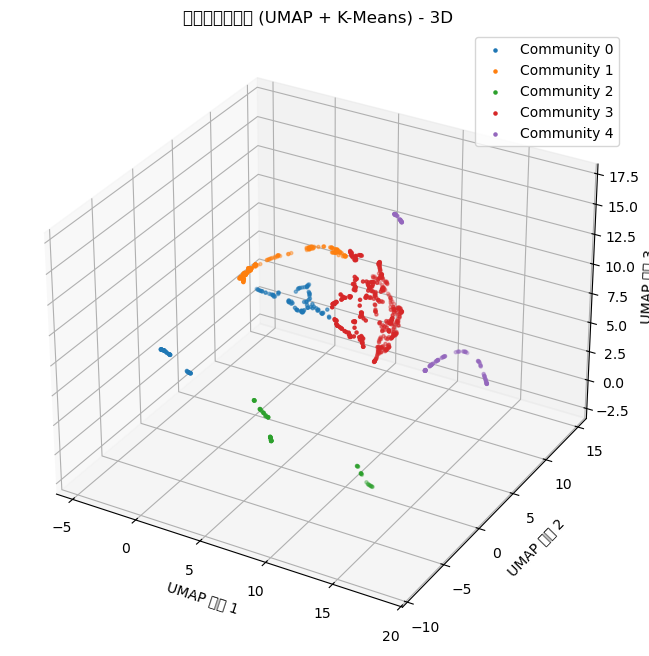

In [102]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster_id in range(num_clusters):
    cluster_points = embeddings_2d[predicted_labels == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               label=f"Community {cluster_id}", s=5)
ax.set_title("社区划分可视化 (UMAP + K-Means) - 3D")
ax.set_xlabel("UMAP 维度 1")
ax.set_ylabel("UMAP 维度 2")
ax.set_zlabel("UMAP 维度 3")
ax.legend()
plt.show()



In [103]:
import plotly.express as px

df_3d = pd.DataFrame({
    'UMAP_1': embeddings_2d[:, 0],
    'UMAP_2': embeddings_2d[:, 1],
    'UMAP_3': embeddings_2d[:, 2],
    'Community': predicted_labels.astype(str)  # 转为字符串类型便于颜色区分
})

# 使用 Plotly Express 进行三维散点图交互式可视化
fig = px.scatter_3d(
    df_3d,
    x='UMAP_1', y='UMAP_2', z='UMAP_3',
    color='Community',
    title="社区划分交互式三维可视化 (UMAP + K-Means)",
    labels={
        "UMAP_1": "UMAP 维度 1",
        "UMAP_2": "UMAP 维度 2",
        "UMAP_3": "UMAP 维度 3"
    }
)
fig.update_traces(marker=dict(size=3))
fig.show()
fig.write_html("plotly_3d.html")

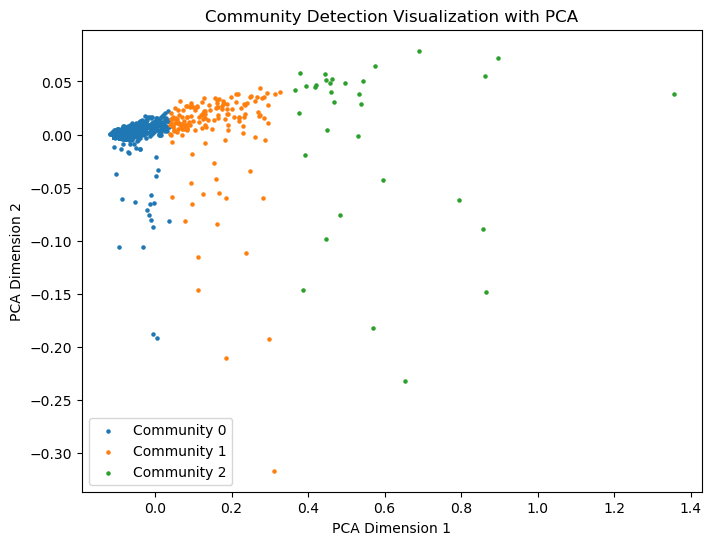

In [19]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设数据和模型已经训练完成，以下是提取社区划分的完整流程

# 1. 获取节点嵌入
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

# 2. 使用 K-Means 进行社区划分
num_clusters = 3  # 社区数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(embeddings.cpu().numpy())

# 3. 使用 PCA 进行降维
pca = PCA(n_components=2)  # 将特征降到 2 维
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# 4. 可视化社区划分结果（根据 PCA 降维后的坐标）
plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = embeddings_2d[predicted_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Community {cluster_id}", s=5)

plt.title("Community Detection Visualization with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()


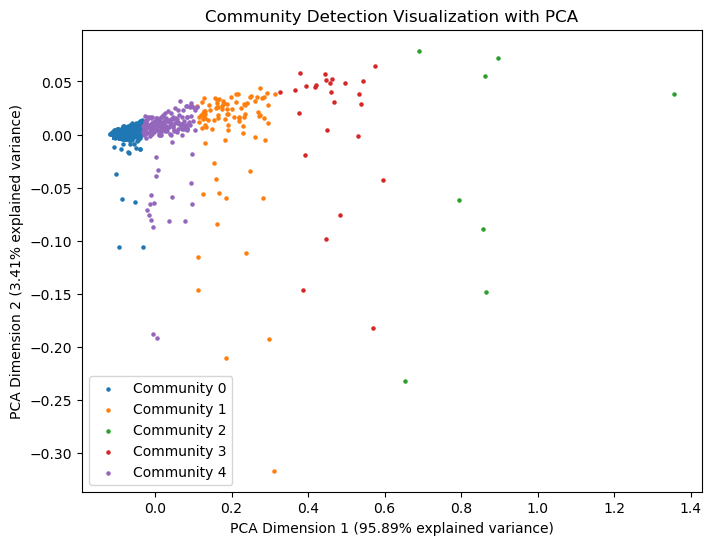

In [20]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假设数据和模型已经训练完成，以下是提取社区划分的完整流程

# 1. 获取节点嵌入
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

# 2. 使用 K-Means 进行社区划分
num_clusters = 5  # 社区数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(embeddings.cpu().numpy())

# 3. 使用 PCA 进行降维
pca = PCA(n_components=2)  # 将特征降到 2 维
embeddings_2d = pca.fit_transform(embeddings.cpu().numpy())

# 获取 PCA 解释方差比率
explained_var_ratio = pca.explained_variance_ratio_

# 4. 可视化社区划分结果（根据 PCA 降维后的坐标）
plt.figure(figsize=(8, 6))
for cluster_id in range(num_clusters):
    cluster_points = embeddings_2d[predicted_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Community {cluster_id}", s=5)

# 添加标题和标签
plt.title("Community Detection Visualization with PCA")
plt.xlabel(f"PCA Dimension 1 ({explained_var_ratio[0]:.2%} explained variance)")
plt.ylabel(f"PCA Dimension 2 ({explained_var_ratio[1]:.2%} explained variance)")
plt.legend()
plt.show()


In [21]:
import torch
import pandas as pd

# 假设数据和模型已经训练完成，以下是提取社区划分的完整流程

# 1. 获取节点嵌入
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(data.edge_index, data.edge_attr, data.x)

# 2. 转换为 Pandas DataFrame 或 NumPy 数组
# 如果你想将特征矩阵输出为 pandas DataFrame 格式
embeddings_df = pd.DataFrame(embeddings.cpu().numpy())

# 或者你也可以直接输出为 NumPy 数组格式
embeddings_np = embeddings.cpu().numpy()

# 输出特征矩阵（这里显示前 5 行以查看内容）
print("Feature Matrix (first 5 rows):")
print(embeddings_df.head())

# 如果你想保存为文件，可以使用以下方式保存：
# 保存为 CSV 文件
embeddings_df.to_csv("/users/lfluo/downloads/embeddings.csv", index=False)

# 保存为 Numpy 文件
import numpy as np
np.save("embeddings.npy", embeddings_np)


Feature Matrix (first 5 rows):
         0         1         2         3         4         5         6   \
0 -0.149567 -0.131284  0.088686  0.024237 -0.013933 -0.020143  0.139004   
1 -0.157788 -0.141880  0.089691  0.030671 -0.012657 -0.016156  0.142967   
2 -0.149472 -0.131035  0.088514  0.024189 -0.013862 -0.020174  0.138741   
3 -0.149633 -0.131457  0.088804  0.024269 -0.013985 -0.020120  0.139185   
4 -0.285238 -0.387657  0.299779  0.206037 -0.014925 -0.019475  0.439640   

         7         8         9         10        11        12        13  \
0  0.018716  0.019837 -0.115542  0.005492  0.002063  0.048960  0.003578   
1  0.030917  0.021491 -0.122024  0.016151  0.001809  0.040938 -0.001361   
2  0.018709  0.019764 -0.115357  0.005535  0.001965  0.048789  0.003437   
3  0.018721  0.019887 -0.115672  0.005460  0.002133  0.049082  0.003680   
4  0.177588  0.108570 -0.248179  0.123494 -0.043800  0.071731 -0.020208   

         14        15  
0 -0.228258 -0.137048  
1 -0.229976 -0.1397

In [22]:
# 评估社区检测
num_communities = 3  # 根据需求设置社区数量
mod, predicted_communities = evaluate(autoencoder, data, embeddings, num_communities=num_communities)


Modularity: 0.1327


In [23]:
import numpy as np

# 假设 embeddings 是一个 PyTorch tensor
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.cpu()

# 转换为 NumPy 数组
embeddings = embeddings.numpy()


In [24]:
# 将 NaN 替换为 0
embeddings = np.nan_to_num(embeddings, nan=0.0)

# 将 Inf 替换为一个较大的数值（例如 1e10）
embeddings[np.isinf(embeddings)] = 1e10


In [ ]:
# 将 NaN 替换为 0
embeddings = np.nan_to_num(embeddings, nan=0.0)

# 将 Inf 替换为一个较大的数值（例如 1e10）
embeddings[np.isinf(embeddings)] = 1e10


In [ ]:
if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
    raise ValueError("Embedding contains NaNs or Infs after processing!")
else:
    print("Embeddings are clean. Proceeding with t-SNE.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def visualize_embeddings(embeddings, predicted_communities):
    """
    使用 t-SNE 对节点嵌入进行降维，并绘制散点图。
    """
    # 确保 embeddings 是 tensor 并在 GPU 上
    if isinstance(embeddings, torch.Tensor):
        # 将 embeddings 从 GPU 移动到 CPU
        embeddings = embeddings.cpu()
    
    # 转换为 NumPy 数组
    embeddings = embeddings.numpy()
    
    # 处理 NaN 和 Inf
    embeddings = np.nan_to_num(embeddings, nan=0.0, posinf=1e10, neginf=-1e10)
    
    # 再次检查是否有 NaN 或 Inf
    if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
        raise ValueError("Embedding contains NaNs or Infs after processing!")
    else:
        print("Embeddings are clean. Proceeding with t-SNE.")
    
    # 使用 t-SNE 降维
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # 绘制
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=predicted_communities, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


In [ ]:
# 可视化嵌入
try:
    visualize_embeddings(embeddings, predicted_communities)
except ValueError as e:
    print(f"Error during visualization: {e}")
    # 根据需要处理错误，例如跳过可视化或记录日志

# 可视化图结构与社区划分
visualize_graph_with_communities(data, predicted_communities)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, predicted_communities):
    """
    使用 t-SNE 对节点嵌入进行降维，并绘制散点图。
    """
    # 使用 t-SNE 降维
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 6))
    # 绘制预测社区
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=predicted_communities, cmap='viridis', s=50)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# 在主函数中调用
visualize_embeddings(embeddings, predicted_communities)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 可视化嵌入
visualize_embeddings(embeddings.cpu().numpy(), predicted_communities)

# 可视化图结构与社区划分
visualize_graph(data, predicted_communities)


In [ ]:
# 评估社区检测
num_communities = 10  # 根据需求设置社区数量
mod, predicted_communities = evaluate(autoencoder, data, embeddings, num_communities=num_communities)

In [ ]:
embeddings = embeddings.cpu().numpy()
embeddings = np.nan_to_num(embeddings, nan=0.0)

# 将 Inf 替换为一个较大的数值（例如 1e10）
embeddings[np.isinf(embeddings)] = 1e10

In [ ]:
def visualize_embeddings(embeddings, predicted_communities):
    """
    使用 t-SNE 对节点嵌入进行降维，并绘制散点图。
    """
    # 如果 embeddings 是 tensor，先将其转换为 numpy 数组
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()

    # 将 NaN 替换为 0
    embeddings = np.nan_to_num(embeddings, nan=0.0)

    # 将 Inf 替换为一个较大的数值（例如 1e10）
    embeddings[np.isinf(embeddings)] = 1e10

    # 使用 t-SNE 降维
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 6))
    # 绘制预测社区
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=predicted_communities, cmap='viridis', s=50)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Embeddings')
    plt.show()

# 假设 embeddings 是一个 tensor 对象，predicted_communities 是预测的社区标签
visualize_embeddings(embeddings, predicted_communities)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 可视化嵌入
visualize_embeddings(embeddings.cpu().numpy(), predicted_communities)

# 可视化图结构与社区划分
visualize_graph(data, predicted_communities)

In [ ]:
def visualize_graph_with_communities(data, predicted_communities):
    """
    可视化图结构与社区划分。每个社区的节点用不同的颜色表示。
    """
    # 创建一个 NetworkX 图对象
    G = nx.Graph()

    # 添加节点及其特征
    for i in range(data.num_nodes):
        G.add_node(i, feature=data.x[i].cpu().numpy())
    
    # 添加边
    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    # 为每个节点添加社区信息
    for node, community in enumerate(predicted_communities):
        G.nodes[node]['community'] = community
    
    # 为了不同社区的节点分配不同的颜色
    communities = list(set(predicted_communities))
    community_colors = {community: plt.cm.get_cmap('tab20')(i / len(communities)) for i, community in enumerate(communities)}
    
    # 绘制网络
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # 布局方式：spring_layout

    # 绘制节点，并根据社区给节点着色
    node_colors = [community_colors[G.nodes[node]['community']] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.7)
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # 绘制标签
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # 标题
    plt.title("Graph Structure with Community Detection", fontsize=15)
    plt.axis('off')
    plt.show()

    # 保存社区划分结果
    save_community_results(predicted_communities)


def save_community_results(predicted_communities):
    """
    将节点和它们的社区划分保存为 CSV 文件。
    """
    # 创建节点编号和社区划分的字典
    community_results = {"Node": list(range(len(predicted_communities))), "Community": predicted_communities}
    df = pd.DataFrame(community_results)

    # 保存为 CSV 文件
    df.to_csv('community_results.csv', index=False)
    print("社区划分结果已保存为 'community_results.csv'。")


In [ ]:
gene_communities = {id_to_name[idx]: comm for idx, comm in enumerate(predicted_communities)}
gene_comm_df = pd.DataFrame(list(gene_communities.items()), columns=['Gene', 'Community'])
gene_comm_df.to_csv('gene_communities3.csv', index=False)
print("社区划分结果已保存为 'gene_communities.csv'。")

In [ ]:

torch.cuda.empty_cache()